# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # применяем табуляцию для раздельного вывода данных
data.info() # изучаем информацию о структуре полученных данных 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [96]:
data.head() # смотрим, как данные выглядят

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

После предварительного знакомства с данными можно сделать следующие выводы: изначальные данные были приготовлены неаккуратно в виде сплошной строки, поэтому была применена табуляция; в самих данных очень много пропусков, так что придется по возможности восстанавливать их; столбец с датами имеет нечитабельный вид, поэтому надо будет привести их в порядок. Предстоит большая работа, так что за дело!

### Шаг 2. Предобработка данных

In [97]:
data.isna().any() # изучаем, в каких столбцах есть пропущенные значения

total_images            False
last_price              False
total_area              False
first_day_exposition    False
rooms                   False
ceiling_height           True
floors_total             True
living_area              True
floor                   False
is_apartment             True
studio                  False
open_plan               False
kitchen_area             True
balcony                  True
locality_name            True
airports_nearest         True
cityCenters_nearest      True
parks_around3000         True
parks_nearest            True
ponds_around3000         True
ponds_nearest            True
days_exposition          True
dtype: bool

In [98]:
data.isna().sum()#так еще информативней

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Итак, после более тщательного анализа выяснилось следующее: данные пропущены в столбцах с значениями высоты потолков, количеством этажей, жилой площадью, является ли жилье апартаментами, площадью кухни, наличием балкона, названием населенного пункта, со всеми геоданными и с датой публикации. Причины пропусков этих данных могут быть различными: такие значения, как балконы и является ли жилье апартаментами, пропущены по причине того, что у людей попросту нет балкона и их жилье не апартаменты, поэтому эти данные несложно восстановить. С геоданными все сложнее, здесь данные потерялись по всей видимости из-за технических сбоев, восстановить такие пропуски можно вручную, но это займет очень много времени, поэтому их придется оставить незаполненными. Значения суммарного количества этажей заполним медианным. А вот значения площади кухни, квартиры и высоты потолков заполнить можно, опираясь на известные значения в столбцах; причина этих пропусков может быть намеренна: люди не захотели раскрывать эти данные для привлечения покупателей. Пропущенные значения в столбце days_exposition мы просто удалим, поскольку нас интересуют только объявления, по которым сделка еще не состоялась. Заполним пропущенные значения!

In [99]:
data.dropna(subset=['days_exposition'], inplace=True) # удаление пропущенных значений 
print(data[data['days_exposition'].isnull()].count()) # проверка на отсутствие пропущенных значений

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


In [100]:
data.dropna(subset=['floors_total'], inplace=True) # удаление пропущенных значений 
print(data[data['floors_total'].isnull()].count()) # проверка на отсутствие пропущенных значений

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


In [101]:
data['ceiling_height'] = data.groupby('floors_total')['ceiling_height'].transform(lambda x: x.fillna(x.median())) # замена с учетом данных по этажам
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(data[data['ceiling_height'].isnull()].count()) # проверка на отсутствие пропущенных значений

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [102]:
data['balcony'] = data['balcony'].fillna(0) # заменяем пропущенные значения на нули
print(data[data['balcony'].isnull()].count()) # проверка на отсутствие пропущенных значений

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


In [103]:
data['is_apartment'] = data['is_apartment'].fillna('False') # заменяем пропущенные значения на False
print(data[data['is_apartment'].isnull()].count()) # проверка на отсутствие пропущенных значений

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


In [104]:
data['airports_nearest'] = data[data['airports_nearest'].notnull()]['airports_nearest'].astype('int')
data['cityCenters_nearest'] = data[data['cityCenters_nearest'].notnull()]['cityCenters_nearest'].astype('int')
data['parks_around3000'] = data[data['parks_around3000'].notnull()]['parks_around3000'].astype('int')
data['parks_nearest'] = data[data['parks_nearest'].notnull()]['parks_nearest'].astype('int')
data['ponds_around3000'] = data[data['ponds_around3000'].notnull()]['ponds_around3000'].astype('int')
data['ponds_nearest'] = data[data['ponds_nearest'].notnull()]['ponds_nearest'].astype('int')
data['last_price'] = data['last_price'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
print(data.info()) # проверка смены типов данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20441 entries, 1 to 23697
Data columns (total 22 columns):
total_images            20441 non-null int64
last_price              20441 non-null int64
total_area              20441 non-null float64
first_day_exposition    20441 non-null object
rooms                   20441 non-null int64
ceiling_height          20441 non-null float64
floors_total            20441 non-null int64
living_area             18766 non-null float64
floor                   20441 non-null int64
is_apartment            20441 non-null object
studio                  20441 non-null bool
open_plan               20441 non-null bool
kitchen_area            18409 non-null float64
balcony                 20441 non-null int64
locality_name           20394 non-null object
airports_nearest        15775 non-null float64
cityCenters_nearest     15797 non-null float64
parks_around3000        15797 non-null float64
parks_nearest           6902 non-null float64
ponds_around3000    

Переводим значения столбцов last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition в целочисленный формат, поскольку для геоданных нам не требуется точность больше, чем 1 метр, а количество этажей и балконов это и так целое число.

In [105]:
print('Всего дубликатов',data.duplicated().sum()) # смотрим, сколько дубликатов в данных

Всего дубликатов 0


In [106]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S') # меняем формат даты-времени
print(data['first_day_exposition'])

1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
5       2018-09-10
           ...    
23691   2016-10-13
23692   2017-07-07
23693   2016-08-05
23695   2018-01-15
23697   2017-03-28
Name: first_day_exposition, Length: 20441, dtype: datetime64[ns]


Предобработка данных завершена, пропущенные значения заполнены или удалены, формат даты приведен к нормальному виду, данные приведены к одному типу. Можно начинать анализ.

### Шаг 3. Посчитайте и добавьте в таблицу

In [107]:
data['level'] = np.where(data['floor'] == 1, 'первый', np.where(data['floor'] == data['floors_total'], 'последний', 'другой'))

In [108]:
data['week_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday # добавляем день недели
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month # добавляем месяц
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year # добавляем год

In [109]:
data['price/square_m'] = data['last_price']/data['total_area'] # добавление цены за квадратаный метр

In [110]:
data['living/total'] = data['living_area']/data['total_area'] # добавляем отношение площади жилой к общей 

In [111]:
data['kitchen/total'] = data['kitchen_area']/data['total_area'] # добавляем отношение площади кухни к общей

In [112]:
data.info() # проверяем, что у нас вышло
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20441 entries, 1 to 23697
Data columns (total 29 columns):
total_images            20441 non-null int64
last_price              20441 non-null int64
total_area              20441 non-null float64
first_day_exposition    20441 non-null datetime64[ns]
rooms                   20441 non-null int64
ceiling_height          20441 non-null float64
floors_total            20441 non-null int64
living_area             18766 non-null float64
floor                   20441 non-null int64
is_apartment            20441 non-null object
studio                  20441 non-null bool
open_plan               20441 non-null bool
kitchen_area            18409 non-null float64
balcony                 20441 non-null int64
locality_name           20394 non-null object
airports_nearest        15775 non-null float64
cityCenters_nearest     15797 non-null float64
parks_around3000        15797 non-null float64
parks_nearest           6902 non-null float64
ponds_around

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,level,week_day,month,year,price/square_m,living/total,kitchen/total
1,7,3350000,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,0.0,NaN,81,первый,1,12,2018,82920.792079,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,2.0,574.0,558,другой,3,8,2015,92785.714286,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.60,14,NaN,9,False,...,3.0,234.0,424,другой,4,7,2015,408176.100629,NaN,NaN
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48.0,121,другой,1,6,2018,100000.000000,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,55,другой,0,9,2018,95065.789474,0.473684,0.299342


Все необходимые столбцы добавлены, проверено, что все добавилось как надо. Пора анализировать!

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

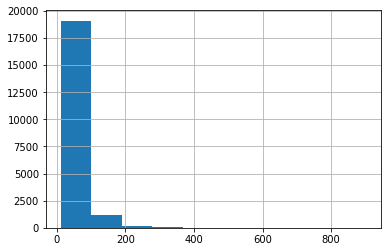

In [113]:
data['total_area'].hist()

Больше всего квартир, площадью до 100 квадратных метров, большие квартиры редкость

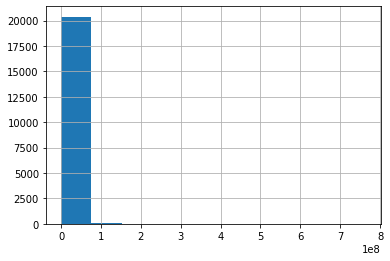

In [114]:
data['last_price'].hist()

Цена за подавляющие большинство квартир не превосходит 80 млн рублей

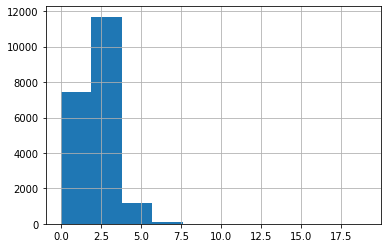

In [115]:
data['rooms'].hist()

В основном продаются 2-3 комнатые квартиры

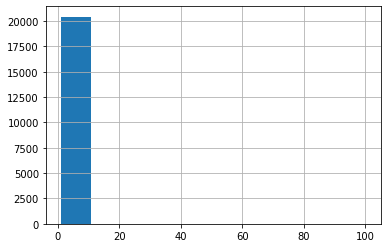

In [116]:
data['ceiling_height'].hist()

Высота потолков укладывается в 10 метров, все логично:)

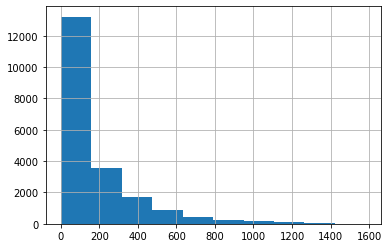

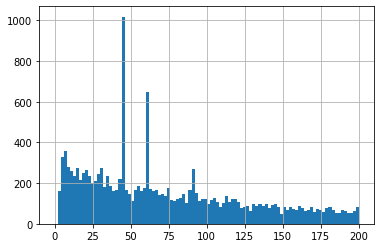

95.0
180.88483929357665


In [117]:
data['days_exposition'].hist()
plt.show()
data['days_exposition'].hist(range=(0,200), bins=100)
plt.show()
print(data['days_exposition'].median())
print(data['days_exposition'].mean())

Из гистрограммы видно, что большая часть квартир была продана в течении 200 дней. Если посмотреть гистограмму на масштабе до 200 дней, то можно заметить, что есть несколько выбросов: наибольшее число продаж за 40-45 дней и 55-60 дней. Исходя из медианного и среднего значений, можно считать, что быстрая продажа - это меньше, чем за 95 дней, а очень долгая, это 800 и более дней.

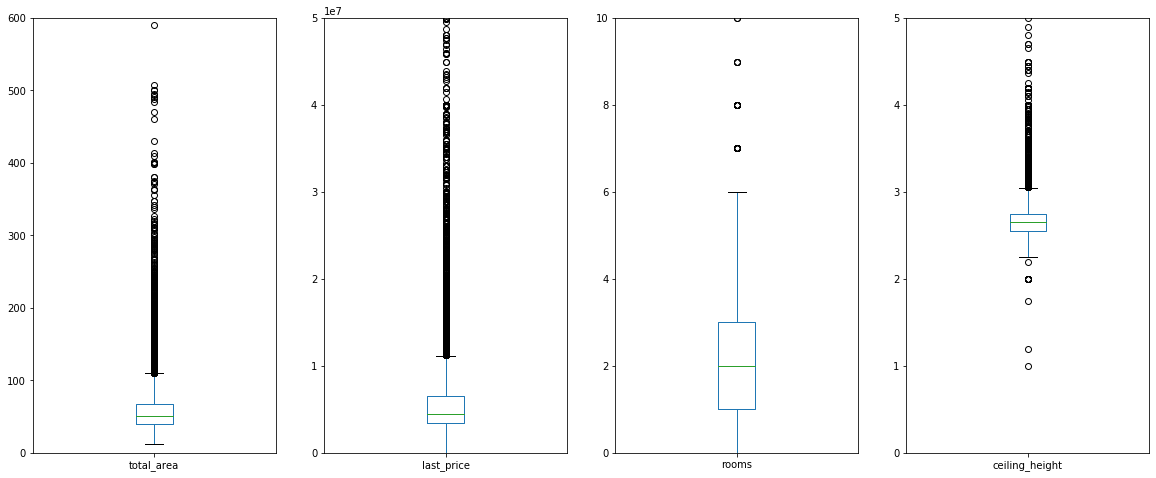

In [118]:
<font color=blue> В эти дни объявления закрывались автоматически.</font>list1 = ['total_area', 'last_price', 'rooms', 'ceiling_height'] # создаем список из интересующих нас параметров
ax = data[list1].plot(kind='box', subplots=True, layout=(1,4), figsize=(20,8)) # строим диаграмму размаха
ylims = [600, 50000000, 10, 5] # указываем индивидуальные границы значений
for i in range(len(list1)):
    ax[list1[i]].set_ylim(0, ylims[i])

Итак, диаграммма размаха показала следующее: по площади смело можно отсекать все, что больше 400 метров, по цене все, что больше 40 млн, по количеству комнат все, что больше 6 и по высоте потолков все, что больше 4 метров. Теперь можно строить графики.

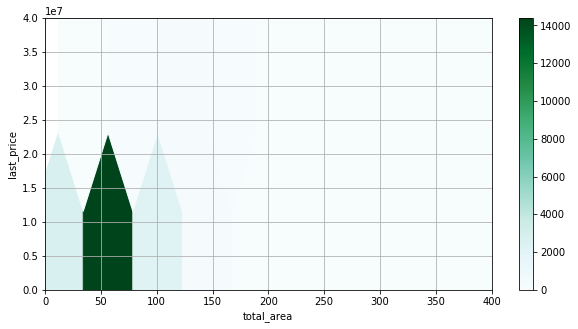

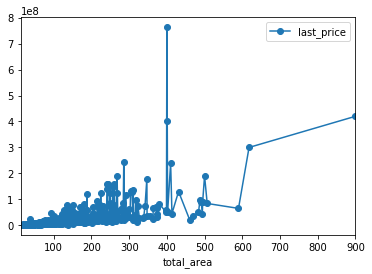

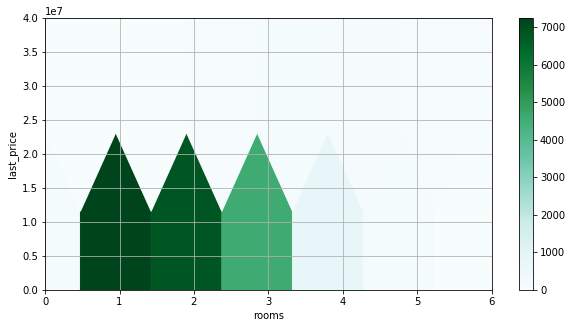

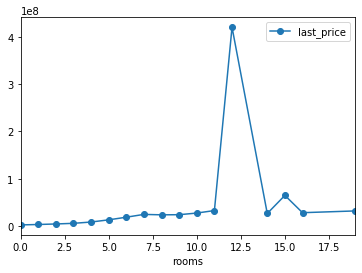

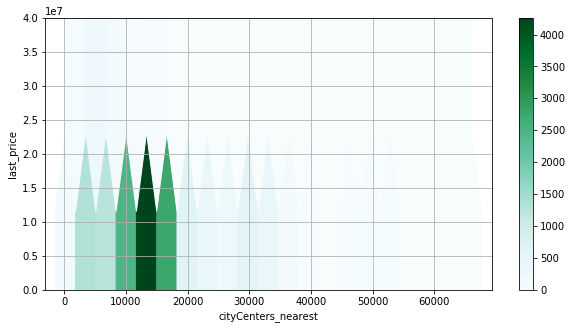

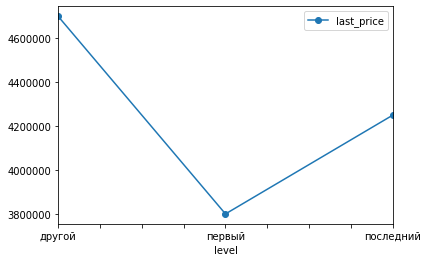

In [119]:
data.sort_values('total_area').plot(y='last_price', x='total_area',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), xlim=(0, 400), grid=True, figsize=(10, 5));
data.pivot_table(index='total_area', values='last_price', aggfunc = 'median').plot(style='o-')
data.sort_values('rooms').plot(y='last_price', x='rooms',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), xlim=(0, 6), grid=True, figsize=(10, 5));
data.pivot_table(index='rooms', values='last_price', aggfunc = 'median').plot(style='o-')
data.sort_values('cityCenters_nearest').plot(y='last_price', x='cityCenters_nearest',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data.pivot_table(index='level', values='last_price', aggfunc = 'median').plot(style='o-')

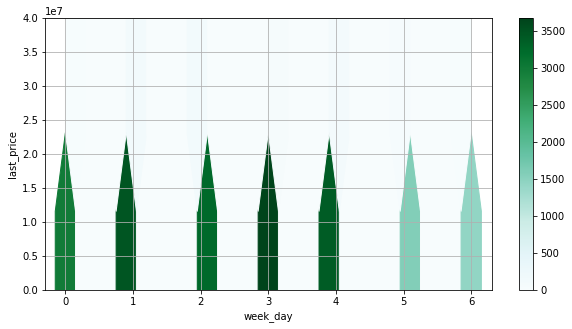

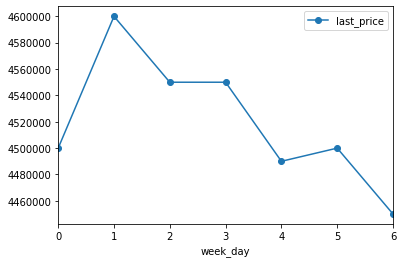

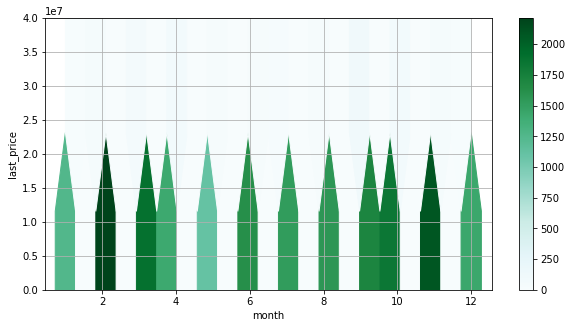

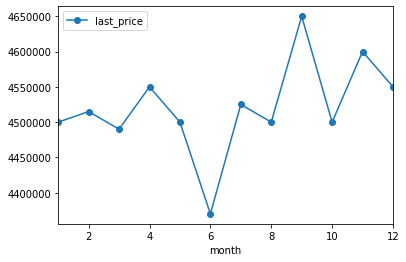

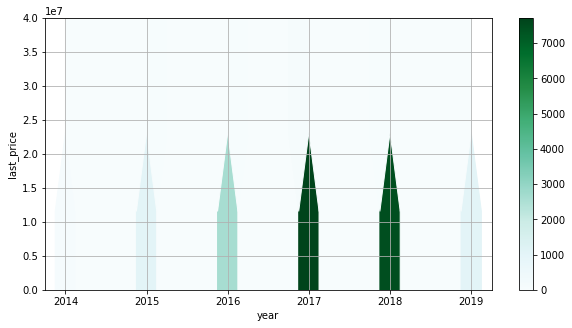

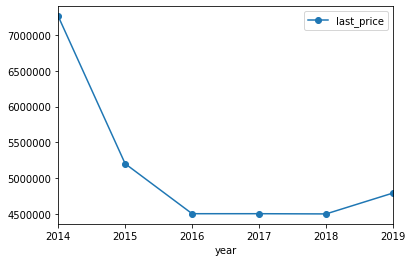

In [36]:
data.sort_values('week_day').plot(y='last_price', x='week_day',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data.pivot_table(index='week_day', values='last_price', aggfunc = 'median').plot(style='o-')
data.sort_values('month').plot(y='last_price', x='month',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data.pivot_table(index='month', values='last_price', aggfunc = 'median').plot(style='o-')
data.sort_values('year').plot(y='last_price', x='year',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data.pivot_table(index='year', values='last_price', aggfunc = 'median').plot(style='o-')

In [121]:
print(data['last_price'].corr(data['total_area'])) # считаем коэффиценты Пирсона
print(data['last_price'].corr(data['rooms']))
print(data['last_price'].corr(data['floor']))
print(data['last_price'].corr(data['cityCenters_nearest']))
print(data['last_price'].corr(data['week_day']))
print(data['last_price'].corr(data['month']))
print(data['last_price'].corr(data['year']))

0.6430754891109266
0.35373733107958844
0.02636140107482712
-0.19287268378340408
0.004369018255038609
0.005595874724701435
-0.060902972086799324


Исходя из графиков и коэффициентов корреляций можно сделать выводы: цена на квартиру почти не зависит от этажности, однако от дня, месяца и года продажи зависимость есть: самые низкие цены были в 2016-2018 годах,самые дорогие квартиры осенью и в будние дни. От площади и количества комнат наблюдается прямая зависимость, от удаленности от центра видна слабая обратная зависимость. Видна зависимость от типа этажа: самые дешевые квартиры на первом этаже (что логично, так как там больше шума и выше вероятность кражи), а самые дорогие, которые не первый и не последний этажи, что так же понятно: с последнего этажа дольше всего спускаться и летом жарче от крыши (и вероятность протекания крыши выше).

In [122]:
print(data['locality_name'].value_counts().sort_values(ascending=False).head(10)) # топ-10 по количеству объявлений
data['top_10'] = data['locality_name'].sort_values(ascending=False).head(10)

Санкт-Петербург      13577
посёлок Мурино         515
посёлок Шушары         407
Всеволожск             339
Колпино                308
Пушкин                 307
посёлок Парголово      302
деревня Кудрово        299
Гатчина                268
Выборг                 208
Name: locality_name, dtype: int64


In [123]:
(data.groupby('locality_name')['price/square_m'] # подробно изучим топ-10
 .agg (['mean','count'])
 .sort_values(by='count', ascending=False).head(10)
 )

,mean,count
locality_name,,
Санкт-Петербург,112438.937808,13577
посёлок Мурино,85738.945051,515
посёлок Шушары,77872.600324,407
Всеволожск,68570.615292,339
Колпино,74865.364347,308
Пушкин,102074.629153,307
посёлок Парголово,89505.043917,302
деревня Кудрово,92473.547576,299
Гатчина,67928.326990,268


Видно, что самая высокая средняя цена в Санкт-Петербурге, самая низкая в Выборге.

                 price/square_m
distance_center                
0.0               226876.498375
1.0               159665.424018
2.0               155742.039092
3.0               116870.770512
4.0               132374.940228
5.0               138812.084651
6.0               147916.592487
7.0               151154.772235
8.0               123782.316864
9.0               110726.491228
10.0              111026.302612
11.0              106203.929729
12.0              106035.513801
13.0              106476.431277
14.0              103017.560883
15.0              102164.241283
16.0               99028.520976
17.0               95918.647693
18.0               95169.581346
19.0               98709.495380
20.0              100954.144273
21.0               91336.872260
22.0               90260.341534
23.0               89830.244101
24.0               85736.904595
25.0               91531.371618
26.0               87832.108756
27.0              132115.709459
28.0               81161.915320
29.0    

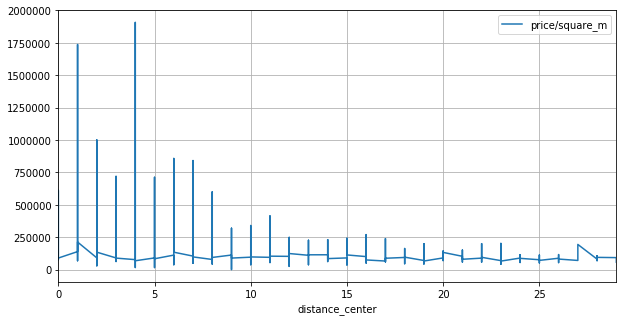

In [124]:
data_spb = data.query('locality_name == "Санкт-Петербург"') # делаем срез
data['distance_center'] = data_spb['cityCenters_nearest']/1000 # переводим в километры
data['distance_center'] = round(data['distance_center']) # округляем до целых
table1 = pd.pivot_table(data, values='price/square_m', index=['distance_center'])
print(table1)
data.sort_values('distance_center').plot(y='price/square_m', x='distance_center',  kind='line',grid=True, figsize=(10, 5));

Исходя из графика, центральная зона определяется радиусом в  10 км (есть изменения).

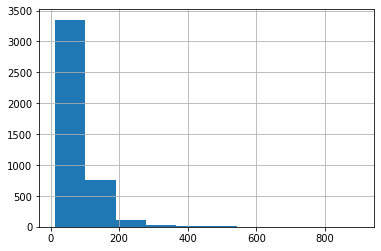

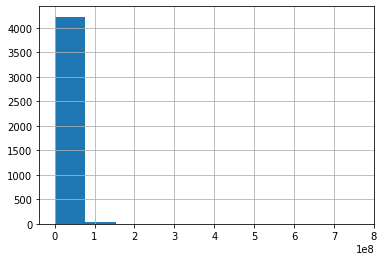

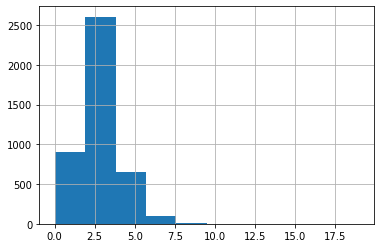

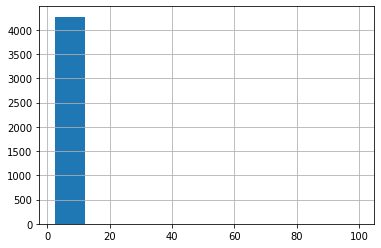

In [125]:
data_center = data_spb.query('cityCenters_nearest < 10000')
data_center['total_area'].hist()
plt.show()
data_center['last_price'].hist()
plt.show()
data_center['rooms'].hist()
plt.show()
data_center['ceiling_height'].hist()
plt.show()

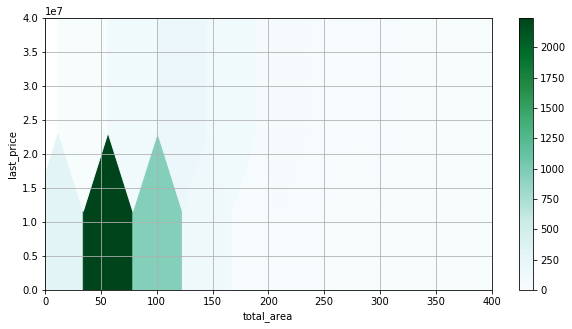

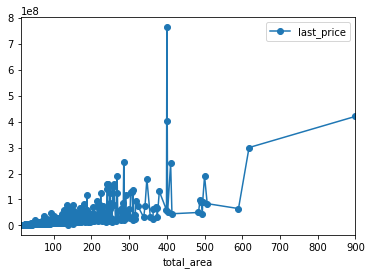

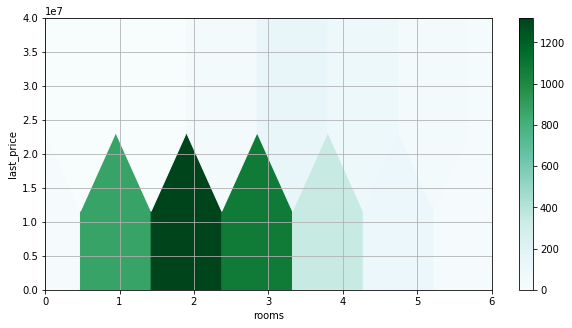

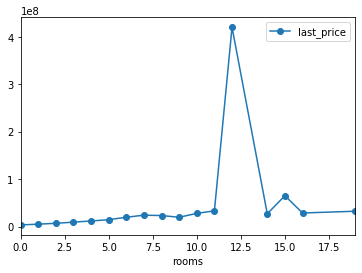

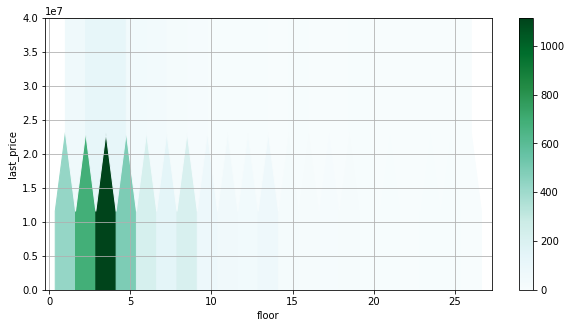

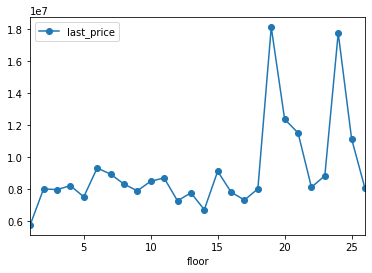

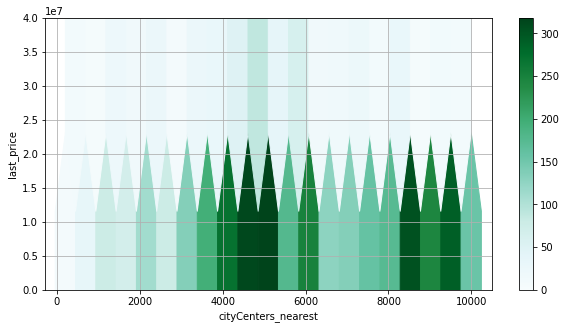

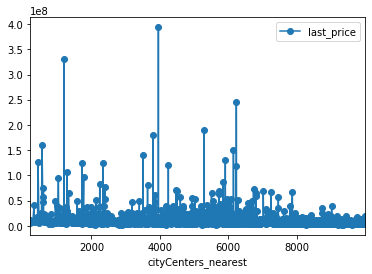

In [127]:
data_center.sort_values('total_area').plot(y='last_price', x='total_area',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), xlim=(0, 400), grid=True, figsize=(10, 5));
data_center.pivot_table(index='total_area', values='last_price', aggfunc = 'median').plot(style='o-')
data_center.sort_values('rooms').plot(y='last_price', x='rooms',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), xlim=(0, 6), grid=True, figsize=(10, 5));
data_center.pivot_table(index='rooms', values='last_price', aggfunc = 'median').plot(style='o-')
data_center.sort_values('floor').plot(y='last_price', x='floor',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data_center.pivot_table(index='floor', values='last_price', aggfunc = 'median').plot(style='o-')
data_center.sort_values('cityCenters_nearest').plot(y='last_price', x='cityCenters_nearest',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5));
data_center.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc = 'median').plot(style='o-')

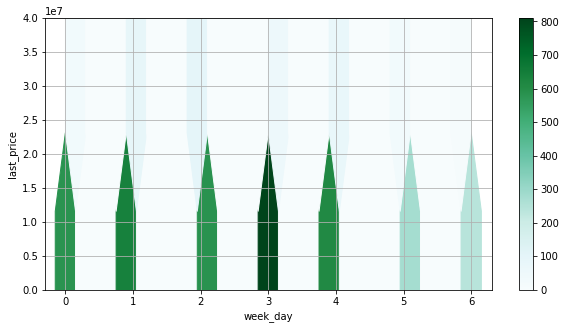

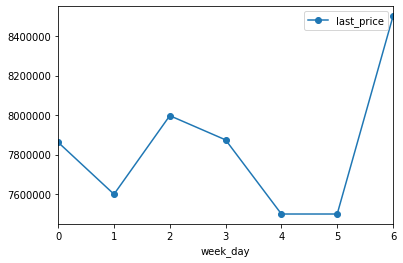

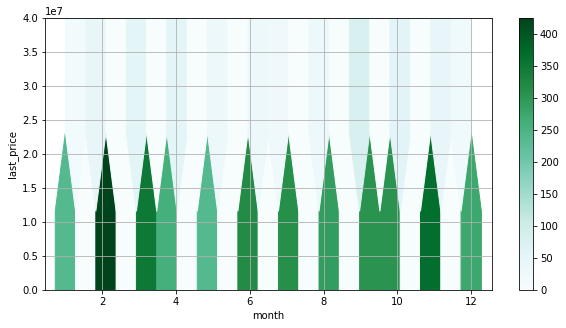

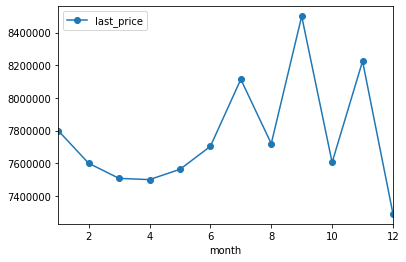

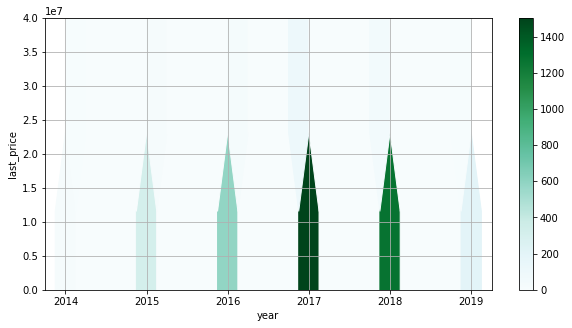

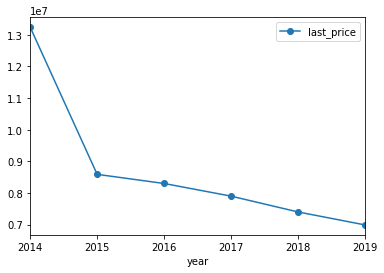

In [128]:
data_center.sort_values('week_day').plot(y='last_price', x='week_day',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5))
data_center.pivot_table(index='week_day', values='last_price', aggfunc = 'median').plot(style='o-')
data_center.sort_values('month').plot(y='last_price', x='month',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5))
data_center.pivot_table(index='month', values='last_price', aggfunc = 'median').plot(style='o-')
data_center.sort_values('year').plot(y='last_price', x='year',  kind='hexbin', gridsize=20, sharex=False, ylim=(0,40000000), grid=True, figsize=(10, 5))
data_center.pivot_table(index='year', values='last_price', aggfunc = 'median').plot(style='o-')

Итак, был исследован центральный сегмент Санкт-Петербурга. И выводы несколько отличаются от предыдущего анализа: покупают наиболее охотно все так же 2-3 комнатные квартиры, площадью от 30 до 80 кв.м и чем больше комнат, тем квартира дороже (весьма логично). Наиболее дорогие квартиры осенью, в выходные дни сделку лучше не совершать (дороже всего), а в целом можно видеть тенденцию снижения цены на недвижимость: с 2014 год уверенное падение (надо брать, пока не поздно!).

### Шаг 5. Общий вывод

После проведенного анализа подведем итоги: цена на квартиру почти не зависит от этажности, однако от дня, месяца и года продажи зависимость есть: самые низкие цены были в 2016-2018 годах,самые дорогие квартиры осенью и в будние дни. От площади и количества комнат наблюдается прямая зависимость, от удаленности от центра видна слабая обратная зависимость. Видна зависимость от типа этажа: самые дешевые квартиры на первом этаже (что логично, так как там больше шума и выше вероятность кражи), а самые дорогие, которые не первый и не последний этажи, что так же понятно: с последнего этажа дольше всего спускаться и летом жарче от крыши (и вероятность протекания крыши выше).
Проанализировав отдельно взятый город - Санкт-Петербург - можно сделать такие выводы: покупают наиболее охотно все так же 2-3 комнатные квартиры, площадью от 30 до 80 кв.м и чем больше комнат, тем квартира дороже (весьма логично). Наиболее дорогие квартиры осенью, в выходные дни сделку лучше не совершать (дороже всего), а в целом можно видеть тенденцию снижения цены на недвижимость: с 2014 год уверенное падение. Однако видна зависимость от даты продаж: в будние дни покупают охотнее, чем в выходные; в марте и ноябре было больше всего продаж и 2017 и 2018 года были самые удачные для риелторов. Наибольший спрос на квартиры, наиболее удаленные от центра (очевидно новые спальные районы).